In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import vgg19, VGG19_Weights
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import copy

from PIL import Image
import matplotlib.pyplot as plt

Content image shape : 224 x 224
Style image shape : 224 x 224
torch.Size([1, 3, 224, 224])


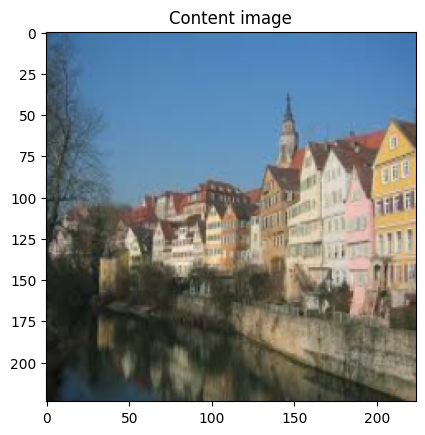

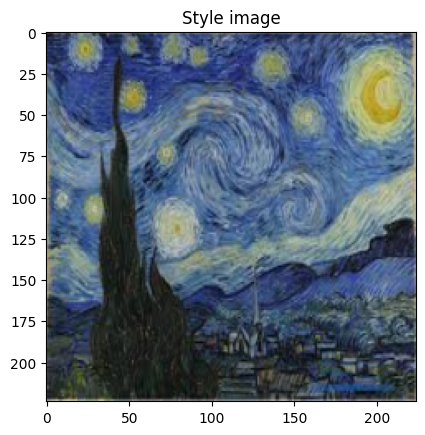

In [2]:
## Load and display images 

# use cuda if it is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# shape of the output image
imshape = (224, 224)

def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imshape),  transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # add an additional dimension for fake batch (here 1)
    return image.to(device, torch.float) # move the image tensor to the correct device

def image_display(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()        # clone the tensor
    image = unloader(image.squeeze(0))  # remove the fake batch dimension
    plt.show()
    plt.imshow(image)
    if title is not None:
        plt.title(title)

image_path = "../data/"
content_image_name = "content.jpeg"
style_image_name = "style.jpeg"

content_image = image_loader(image_path + content_image_name)
style_image = image_loader(image_path + style_image_name)

content_height, content_width = content_image.shape[2], content_image.shape[3]
style_height, style_width = style_image.shape[2], style_image.shape[3]

print(f"Content image shape : {content_height} x {content_width}")
print(f"Style image shape : {style_height} x {style_width}")
print(content_image.size())
image_display(content_image, "Content image")
image_display(style_image, "Style image")

In [3]:
def get_content_loss(input, target):
    return F.mse_loss(input, target)

def gram_matrix(input):
    a, b, c, d = input.size()  
    # a = batch size, 
    # b = number of feature maps, 
    # c, d = height, width
    features = input.view(a * b, c * d)   # flatten the feature maps
    G = torch.mm(features, features.t())  # compute the dot product of the feature maps
    return G.div(a * b * c * d)           # normalize the Gram matrix

def get_style_loss(input, target):
    G_input = gram_matrix(input)
    G_target = gram_matrix(target)
    return F.mse_loss(G_input, G_target)

# We use the PyTorch module made by Alexis Jacq for Neural Style Transfer components
class ContentLoss(nn.Module):
    """
    Computes the content loss between the input and the target feature maps.

    Attributes:
    ------------
    target : torch.Tensor
        The target feature map (detached to avoid gradient computation).

    Methods:
    ---------
    forward(input):
        Computes the content loss using the input feature map.
        Returns the input for compatibility with sequential models.
    """

    def __init__(self, target):
        """
        Initializes the ContentLoss module.

        Parameters:
        ------------
        target : torch.Tensor
            The target feature map from a specific layer of the model.
        """
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # Detach target to avoid affecting gradients

    def forward(self, input):
        """
        Computes the content loss between the input and the target feature map.

        Parameters:
        ------------
        input : torch.Tensor
            The input feature map from the same layer.

        Returns:
        ------------
        torch.Tensor
            The unchanged input feature map (needed for seamless integration in the model).
        """
        self.loss = get_content_loss(input, self.target)  # Store the loss
        return input  # Pass the input through unchanged


class StyleLoss(nn.Module):
    """
    Computes the style loss between the input and the target feature maps.

    Attributes:
    ------------
    target : torch.Tensor
        The target feature map (detached to avoid gradient computation).

    Methods:
    ---------
    forward(input):
        Computes the style loss using the input feature map.
        Returns the input for compatibility with sequential models.
    """

    def __init__(self, target_feature):
        """
        Initializes the StyleLoss module.

        Parameters:
        ------------
        target_feature : torch.Tensor
            The target feature map used for style loss computation.
        """
        super(StyleLoss, self).__init__()
        self.target = target_feature.detach()  # Detach target to avoid affecting gradients

    def forward(self, input):
        """
        Computes the style loss between the input and the target feature map.

        Parameters:
        ------------
        input : torch.Tensor
            The input feature map from the same layer.

        Returns:
        ------------
        torch.Tensor
            The unchanged input feature map (needed for seamless integration in the model).
        """
        self.loss = get_style_loss(input, self.target)  # Store the loss
        return input  # Pass the input through unchanged


class Normalization(nn.Module):
    """
    Normalizes an image using the mean and standard deviation of the dataset.

    Attributes:
    ------------
    mean : torch.Tensor
        The mean values for each channel (reshaped to match image dimensions).
    std : torch.Tensor
        The standard deviation values for each channel (reshaped to match image dimensions).

    Methods:
    ---------
    forward(img):
        Normalizes the input image tensor using the mean and standard deviation.
    """

    def __init__(self, mean, std):
        """
        Initializes the Normalization module.

        Parameters:
        ------------
        mean : list or torch.Tensor
            The mean values for each channel (e.g., for ImageNet: [0.485, 0.456, 0.406]).
        std : list or torch.Tensor
            The standard deviation values for each channel (e.g., for ImageNet: [0.229, 0.224, 0.225]).
        """
        super(Normalization, self).__init__()
        # Convert mean and std to tensors and reshape for broadcasting across the image dimensions
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        """
        Normalizes the input image.

        Parameters:
        ------------
        img : torch.Tensor
            The input image tensor to be normalized.

        Returns:
        ------------
        torch.Tensor
            The normalized image tensor.
        """
        return (img - self.mean) / self.std  # Apply normalization

In [4]:
### Load the VGG-19 pretrained model 
model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).to(device) # move the model to the correct device
print(model)
print("Features layers :")
print(model.children())

print("Classification layers:")
print(model.classifier)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv4_2']
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Copy our model to iterate on the layers after
model = model.features.eval() # set the model to evaluation mode

vgg = copy.deepcopy(model)

# Define the normalization parameters based on the values 
# recommended in the PyTorch VGG-19 model documentation.
model_normalization_mean = [0.485, 0.456, 0.406]
model_normalization_std = [0.229, 0.224, 0.225]

# Create a normalization layer with specified mean and std
normalization = Normalization(model_normalization_mean, model_normalization_std).to(device)

# Add the layer to our model
model = nn.Sequential(normalization)

In [6]:
print(model)

Sequential(
  (0): Normalization()
)


In [7]:
blocks = [2, 2, 4, 4, 4]  # Number of convolutional layers in each block of the VGG-19 model

# Noms des couches pour les pertes de contenu et de style
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
content_layer = 'conv4_2'

style_losses = []
content_losses = []
index_conv = 0
current_block = 0

model = nn.Sequential()  # Nouveau modèle séquentiel
i = 0  # Compteur global des couches

for layer in vgg.children():
    # Vérifier si on doit passer au bloc suivant
    if current_block < len(blocks) and index_conv == blocks[current_block]:
        index_conv = 0  # Réinitialiser le compteur pour le nouveau bloc
        current_block += 1

    if isinstance(layer, nn.Conv2d):  # Pour les couches convolutionnelles
        index_conv += 1
        name = f'conv{current_block + 1}_{index_conv}'
        model.add_module(name, layer)  # Ajouter la couche au modèle

        # Ajouter les pertes de style et de contenu
        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

        if name == content_layer:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

    elif isinstance(layer, nn.ReLU):  # Pour les couches ReLU
        name = f'relu{current_block + 1}_{index_conv}'
        model.add_module(name, nn.ReLU(inplace=False))
        
    elif isinstance(layer, nn.MaxPool2d):  # Pour les couches MaxPooling
        name = f'pool{current_block + 1}'
        model.add_module(name, layer)

    i += 1

# Afficher les premières couches pour vérifier les noms
print(model)

Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_0): StyleLoss()
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_0): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_0): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_10): StyleLoss()
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (conv3_4): Conv2d(256,

In [8]:
# Since the last layer is a loss function, we iterate from the end of the model
# and stop when we encounter the first content or style loss layer.
for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
model = model[:i + 1]

for name, layer in model.named_children():
    print(name, layer)

conv1_1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_0 StyleLoss()
relu1_1 ReLU()
conv1_2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu2_0 ReLU()
pool2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2_1 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_5 StyleLoss()
relu2_1 ReLU()
conv2_2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_0 ReLU()
pool3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv3_1 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_10 StyleLoss()
relu3_1 ReLU()
conv3_2 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_2 ReLU()
conv3_3 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_3 ReLU()
conv3_4 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu4_0 ReLU()
pool4 MaxPool2d(kernel_size=2, stride=2,

<Figure size 640x480 with 0 Axes>

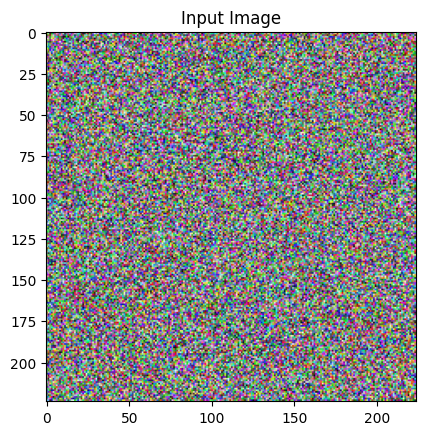

In [9]:
style_weight = 1000000
content_weight = 1

# The initialization of the image is a random noise
input_image = torch.randn(content_image.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
image_display(input_image, title='Input Image')

In [10]:
# as in the thesis, we choose L-BFGS for the optimization
optimizer = optim.LBFGS([input_image.requires_grad_()])

In [ ]:
torch.autograd.set_detect_anomaly(True)

num_steps = 10000

step_counter = [0]
while step_counter[0] <= num_steps:

    # Recall function for the optimiser
    def closure():

        optimizer.zero_grad()     # do not accumulate parameter gradients
        model(input_image)        # passes the image as input to the model
        style_score = 0
        content_score = 0

        # add up the losses for each style layer
        for style_loss in style_losses:
            style_score += style_loss.loss

        # add up the losses for each content layer
        for content_loss in content_losses:
            content_score += content_loss.loss

        # apply the weights
        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score # calculate the total loss
        loss.backward()                    # backward to calculate the gradients of the input image

        step_counter[0] += 1

        if step_counter[0] % 50 == 0:      # display style and content scores every 50 steps
            print("step {}:".format(step_counter[0]))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score

    optimizer.step(closure)

input_image.data.clamp_(0, 1)

step 50:
Style Loss : 136.596268 Content Loss: 26.528070

step 100:
Style Loss : 45.904285 Content Loss: 20.134024



In [ ]:
image_display(input_image)

image_display(input_image, title='Output Image')